<a href="https://colab.research.google.com/github/woutervantol/scriptie1/blob/master/Copy_of_tot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install hcipy
from hcipy import *
import numpy as np
import matplotlib.pyplot as plt
# from perlin_noise import PerlinNoise
import time
from tensorflow import keras
from IPython.display import clear_output

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 241 kB 8.3 MB/s 
     |████████████████████████████████| 448 kB 55.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 212 kB 53.0 MB/s 
     |████████████████████████████████| 68 kB 8.5 MB/s 
     |████████████████████████████████| 191 kB 59.5 MB/s 
     |████████████████████████████████| 56 kB 5.6 MB/s 
  Created wheel for asdf: filename=asdf-2.10.0-py3-none-any.whl size=403892 sha256=e43207b9c4328734fc50e20005e72221954526bfd1ebe911ebf9c0150f8bbe94
  Stored in directory: /root/.cache/pip/wheels/92/84/75/9da5925b0f485a0e79d798ff4c4c01c7bb3962f060b2401645
Successfully built asdf
  Attempting uninstall: jsonschema
    Found existing installation: jsonschema 4.3.3
    Uninstalling jsonschema-4.3.3:
      Successfully uninstalled js

Mounted at /content/gdrive


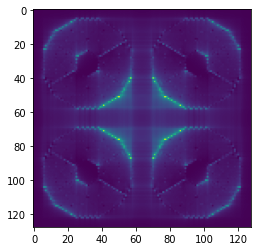

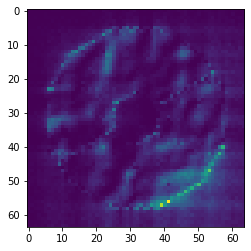

In [3]:
#Sync data with drive
from google.colab import drive
drive.mount('/content/gdrive')

#save data
# !cp /content/reconstructionMatrix.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/image_ref.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/trainx.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/trainy.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/testx.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/testy.npy "/content/gdrive/MyDrive/MasterThesis/Data/"

# !cp /content/reconstructionMatrixMod.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/image_refMod.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/trainxMod.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/trainyMod.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/testxMod.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/testyMod.npy "/content/gdrive/MyDrive/MasterThesis/Data/"

# mod = "Mod"
mod = ""
matrix = np.load("/content/gdrive/MyDrive/MasterThesis/Data/reconstructionMatrix{}.npy".format(mod))
image_ref = np.load("/content/gdrive/MyDrive/MasterThesis/Data/image_ref{}.npy".format(mod))
trainx = np.load("/content/gdrive/MyDrive/MasterThesis/Data/trainx{}.npy".format(mod))
trainy = np.load("/content/gdrive/MyDrive/MasterThesis/Data/trainy{}.npy".format(mod))
testx = np.load("/content/gdrive/MyDrive/MasterThesis/Data/testx{}.npy".format(mod))
testy = np.load("/content/gdrive/MyDrive/MasterThesis/Data/testy{}.npy".format(mod))
plt.imshow(image_ref.reshape(128, 128))
plt.show()
plt.imshow(trainx[500,:,0].reshape(64, 64))
plt.show()

In [4]:
#initialization
wavelength_wfs = 1e-6
telescope_diameter = 39.3
zero_magnitude_flux = 3.9E10
num_pupil_pixels = 256
num_pwfs_pixels = 128
pupil_grid_diameter = telescope_diameter
pupil_grid = make_pupil_grid(num_pupil_pixels, pupil_grid_diameter)
pwfs_grid = make_pupil_grid(num_pwfs_pixels, 1.2*2*pupil_grid_diameter)

make_aperture = make_elt_aperture()
aperture = evaluate_supersampled(make_aperture, pupil_grid, 6)

num_actuators_across_pupil = 20
actuator_spacing = telescope_diameter / num_actuators_across_pupil
influence_functions = make_gaussian_influence_functions(pupil_grid, num_actuators_across_pupil, actuator_spacing)
#verander dit hierboven naar make_zernike_basis

nr_runs = 100
rmslist = np.logspace(np.log10(0.01), np.log10(4.0), 10)

deformable_mirror = DeformableMirror(influence_functions)
num_modes = deformable_mirror.num_actuators

pwfs = PyramidWavefrontSensorOptics(pupil_grid, pwfs_grid, separation=1.2*pupil_grid_diameter, pupil_diameter=telescope_diameter, wavelength_0=wavelength_wfs, q=4)
mpwfs = ModulatedPyramidWavefrontSensorOptics(pwfs, 3*wavelength_wfs/telescope_diameter)
wf = Wavefront(aperture, wavelength_wfs)

def modavg(modlist):
  avg = np.zeros(num_pwfs_pixels**2)
  for i in range(len(modlist)):
    avg += modlist[i].intensity / len(modlist)
  return avg / np.sum(avg)

# image_ref = pwfs.forward(wf).intensity
# image_ref /= np.sum(image_ref)
# # image_ref = modavg(mpwfs.forward(wf))
# plt.imshow(image_ref.reshape(128, 128))
# plt.colorbar()
# plt.show()
# np.save("./image_ref", image_ref)

In [41]:
#generate reconstruction matrix
def make_reconstruction_matrix(rcond=1e-15):
  probe_amp = 0.01 * wavelength_wfs /(2*np.pi) #in rad
  slopes = []

  for ind in range(num_modes):
      if ind % 100 == 0:
          print("Measure response to mode {:d} / {:d}".format(ind+1, num_modes))
      slope = 0

      for s in [1, -1]:
          amp = np.zeros((num_modes,))
          amp[ind] = s * probe_amp
          deformable_mirror.actuators = amp
          dm_wf = deformable_mirror.forward(wf)

          if mod=="":
            wfs_wf = pwfs.forward(dm_wf)
            image = wfs_wf.intensity
            image /= np.sum(image)
          else:
            wfs_wf = mpwfs.forward(dm_wf)
            image = modavg(wfs_wf)

          slope += s * (image-image_ref)/(2 * probe_amp)

      slopes.append(slope)
  slopes = ModeBasis(slopes)
  # rcond = 1E-15
  matrix = inverse_tikhonov(slopes.transformation_matrix, rcond=rcond, svd=None)
  return matrix


np.save("./reconstructionMatrix{}".format(mod), make_reconstruction_matrix(rcond=1e-1))

Measure response to mode 1 / 400
Measure response to mode 101 / 400
Measure response to mode 201 / 400
Measure response to mode 301 / 400


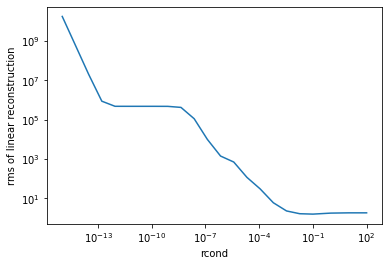

[1.76730560e+10 5.99303625e+08 2.01479797e+07 8.60040665e+05
 4.72679364e+05 4.71655482e+05 4.71650667e+05 4.71580436e+05
 4.69501388e+05 4.15321022e+05 1.10243951e+05 9.78249686e+03
 1.38912268e+03 6.89791382e+02 1.14328671e+02 2.96317736e+01
 5.84757203e+00 2.23456634e+00 1.61479163e+00 1.54075656e+00
 1.54075656e+00 1.73334634e+00 1.78842533e+00 1.78921905e+00]
[1.00000000e-15 5.45559478e-15 2.97635144e-14 1.62377674e-13
 8.85866790e-13 4.83293024e-12 2.63665090e-11 1.43844989e-10
 7.84759970e-10 4.28133240e-09 2.33572147e-08 1.27427499e-07
 6.95192796e-07 3.79269019e-06 2.06913808e-05 1.12883789e-04
 6.15848211e-04 3.35981829e-03 1.83298071e-02 1.00000000e-01
 1.00000000e-01 1.00000000e+00 1.00000000e+01 1.00000000e+02]


In [35]:
#calculate best rcond
transf_matrix = influence_functions.transformation_matrix.toarray().transpose()*2
measurements = np.zeros((len(testx), num_pwfs_pixels, num_pwfs_pixels))
h = int(num_pwfs_pixels/2)
measurements[:, :h, :h] = testx[:, :, 0].reshape(len(testx), h, h)
measurements[:, h:, :h] = testx[:, :, 1].reshape(len(testx), h, h)
measurements[:, :h, h:] = testx[:, :, 2].reshape(len(testx), h, h)
measurements[:, h:, h:] = testx[:, :, 3].reshape(len(testx), h, h)
measurements = measurements.reshape(len(testx), num_pwfs_pixels**2)
opd_dm_states = np.matmul(testy, transf_matrix)

outputs = []
inputs = np.logspace(-10, 5, 16)
for i in inputs:
  rcondtestmatrix = make_reconstruction_matrix(i)
  matrixpredictions = np.matmul(measurements - image_ref[None,:], rcondtestmatrix.transpose())
  opd_matrixpredictions = np.matmul(matrixpredictions, transf_matrix)
  rms = np.sqrt(np.sum((opd_matrixpredictions - opd_dm_states)**2, axis=1) / np.sum(aperture)) / wavelength_wfs * 2*np.pi
  outputs.append(rms)
  print(rms, i)
plt.semilogx(inputs, outputs)
plt.xlabel("rcond")
plt.ylabel("rms of linear reconstruction")
plt.show()


inputs = np.append(np.logspace(-15, -1, 20), np.logspace(-1, 2, 4))
# print(len(inputs))
# test = np.average(outputs, axis=1)
# print(len(inputs))
plt.loglog(inputs, np.average(outputs, axis=1))
plt.xlabel("rcond")
plt.ylabel("rms of linear reconstruction")
plt.show()
# print(test)
print(np.average(outputs, axis=1))
print(inputs)

In [ ]:
#generate data
def random_noise(rms):
    amplitude = rms*wavelength_wfs/(2*np.pi)
    noise = np.random.randn(num_actuators_across_pupil, num_actuators_across_pupil).flatten() * amplitude
    return noise
  
def makeData(rms):
    deformable_mirror.actuators = random_noise(rms)

    dm_wf = deformable_mirror.forward(wf)
    if mod == "":
      pwfs_wf = pwfs.forward(dm_wf)
      image = pwfs_wf.intensity
      image /= np.sum(image)
    else:
      mpwfs_wf = mpwfs.forward(dm_wf)
      image = modavg(mpwfs_wf)
    nr_photons = 1e6
    image = np.random.poisson(image*nr_photons)
    image_ref = image/np.sum(image)
    return image_ref.reshape(num_pwfs_pixels, num_pwfs_pixels), deformable_mirror.actuators


#trainingdata
def generate_data():
  trainx = np.ndarray((nr_runs*len(rmslist), int(num_pwfs_pixels/2)**2, 4))
  trainy = np.ndarray((nr_runs*len(rmslist), num_actuators_across_pupil**2))
  for run in range(nr_runs):
      for rms_idx in range(len(rmslist)):
          measurement, dm_state = makeData(rmslist[rms_idx])
          rowposition = rms_idx * nr_runs + run
          trainy[rowposition] = dm_state
          h = int(num_pwfs_pixels/2)
          trainx[rowposition,:,0] = measurement[:h, :h].flatten()
          trainx[rowposition,:,1] = measurement[h:, :h].flatten()
          trainx[rowposition,:,2] = measurement[:h, h:].flatten()
          trainx[rowposition,:,3] = measurement[h:, h:].flatten()
      if run%10 == 0:
        print(run, nr_runs)
  np.save("./trainx{}".format(mod), trainx)
  np.save("./trainy{}".format(mod), trainy)


  #testdata
  testx = np.ndarray((nr_runs*len(rmslist), int(num_pwfs_pixels/2)**2, 4))
  testy = np.ndarray((nr_runs*len(rmslist), num_actuators_across_pupil**2))
  for run in range(nr_runs):
      for rms_idx in range(len(rmslist)):
          measurement, dm_state = makeData(rmslist[rms_idx])
          rowposition = rms_idx * nr_runs + run
          testy[rowposition] = dm_state
          h = int(num_pwfs_pixels/2)
          testx[rowposition,:,0] = measurement[:h, :h].flatten()
          testx[rowposition,:,1] = measurement[h:, :h].flatten()
          testx[rowposition,:,2] = measurement[:h, h:].flatten()
          testx[rowposition,:,3] = measurement[h:, h:].flatten()
      if run%10 == 0:
        print(run, nr_runs)
  np.save("./testx{}".format(mod), testx)
  np.save("./testy{}".format(mod), testy)

# generate_data()

0


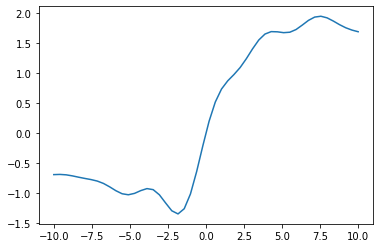

In [ ]:
#plot response
def plot_response(noise_amp=0):
  inputs = np.linspace(-10, 10, 50)
  outputs = []
  noise = random_noise(noise_amp)
  for i in inputs:
    amplitude = i * wavelength_wfs /(2*np.pi)
    # amps = np.zeros((num_actuators_across_pupil**2,))
    amps = noise
    amps[int((num_actuators_across_pupil**2)/2) - 5] = amplitude
    deformable_mirror.actuators = amps
    dm_wf = deformable_mirror.forward(wf)
    if mod=="":
      wfs_wf = pwfs.forward(dm_wf)
      image = wfs_wf.intensity
      image /= np.sum(image)
    else:
      wfs_wf = mpwfs.forward(dm_wf)
      image = modavg(wfs_wf)
    matrixprediction = np.matmul(matrix, image - image_ref)
    output = matrixprediction[int((num_actuators_across_pupil**2)/2)-5] / wavelength_wfs *(2*np.pi)
    outputs.append(output)
    # plt.imshow(image.reshape(128, 128))
    # plt.show()
    # deformable_mirror.actuators = matrixprediction
    # plt.imshow((deformable_mirror.opd*aperture).reshape(256, 256))
    # plt.show()
    # deformable_mirror.actuators = amps
    # plt.imshow((deformable_mirror.opd*aperture).reshape(256, 256))
    # plt.show()
  print(noise_amp)
  plt.plot(inputs, outputs, label="{} rms noise".format(noise_amp))

plot_response()
plt.show()

# plt.plot(np.linspace(-1, 1, 10), np.linspace(-1, 1, 10), ls="dashed", lw=1)
# for noiseamp in [0, 0.1, 0.5, 1, 1.5, 2, 2.5]:
#   plot_response(noiseamp)
# plt.legend()
# plt.show()


In [ ]:
#PAPER MODEL
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(int(num_pwfs_pixels/2), int(num_pwfs_pixels/2), 4), data_format="channels_last"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(32, (3, 3), activation="relu", strides=2, padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(4, (1, 1), padding="same"))
model.add(keras.layers.BatchNormalization())
# model.add(layers.Dropout(0.4))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(400, activation="linear", kernel_regularizer=keras.regularizers.L1(l1=1e-6)))
model.summary()

#SHUFFLE DATA
# trainx = np.load("./trainx{}.npy".format(mod))
# trainy = np.load("./trainy{}.npy".format(mod))
shuffle_indices = np.arange(len(trainx))
np.random.shuffle(shuffle_indices)
trainx = trainx[shuffle_indices]
trainy = trainy[shuffle_indices]

datavars = np.sqrt(np.var(trainx, axis=1))
labelvars = np.sqrt(np.var(trainy, axis=1))
data = trainx / datavars[:,None]
labels = trainy / labelvars[:,None]

model.compile(
    loss=keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[keras.metrics.MeanSquaredError()],
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        1184      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_2 (Batc  (None, 32, 32, 32)       1

In [ ]:
#MY MODEL
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (4, 4), padding="same", input_shape=(int(num_pwfs_pixels/2), int(num_pwfs_pixels/2), 4), data_format="channels_last"))
model.add(keras.layers.LeakyReLU(alpha=0.05))
# model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(64, (4, 4), strides=2, padding="same"))
model.add(keras.layers.LeakyReLU(alpha=0.05))
# model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(64, (4, 4), strides=2, padding="same"))
model.add(keras.layers.LeakyReLU(alpha=0.05))
# model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(64, (4, 4), padding="same"))
model.add(keras.layers.LeakyReLU(alpha=0.05))
# model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size = (2, 2)))
# model.add(keras.layers.Conv2D(64, (4, 4), padding="same"))
# model.add(keras.layers.LeakyReLU(alpha=0.05))
# model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024, kernel_regularizer=keras.regularizers.L1L2(l1=1e-6, l2=1e-4)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(keras.layers.Dense(400, activation="linear"))
model.summary()

#SHUFFLE DATA
# trainx = np.load("./trainxmod.npy")
# trainy = np.load("./trainymod.npy")
shuffle_indices = np.arange(len(trainx))
np.random.shuffle(shuffle_indices)
trainx = trainx[shuffle_indices]
trainy = trainy[shuffle_indices]

datavars = np.sqrt(np.var(trainx, axis=1))
labelvars = np.sqrt(np.var(trainy, axis=1))
data = trainx / datavars[:,None]
labels = trainy / labelvars[:,None]


model.compile(
    loss=keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
    optimizer=keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9),
    metrics=[keras.metrics.MeanSquaredError()],
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        2080      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 64, 64, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 64)        32832     
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                      

In [ ]:
class debugCallback(keras.callbacks.Callback):
  def __init__(self):
    self.losses = []
    self.vallosses = []
    self.epochs = []
  def on_epoch_end(self, epoch, logs=None):
    self.losses.append(logs["loss"])
    self.vallosses.append(logs["val_loss"])
    self.epochs.append(epoch)
    index = np.random.randint(0, len(trainx))
    if epoch%10==0:
      self.plot_losses()
      # self.plot_input(index)
      # self.plot_output(index)
  
  def plot_losses(self):
    clear_output()
    plt.plot(self.epochs, self.losses, label="loss")
    plt.plot(self.epochs, self.vallosses, label="val_loss")
    plt.legend()
    plt.title("losses")
    plt.show()
  def plot_input(self, index):
    measurement = np.zeros((num_pwfs_pixels, num_pwfs_pixels))
    h = int(num_pwfs_pixels/2)
    measurement[:h, :h] = testx[index, :, 0].reshape(h, h)
    measurement[h:, :h] = testx[index, :, 1].reshape(h, h)
    measurement[:h, h:] = testx[index, :, 2].reshape(h, h)
    measurement[h:, h:] = testx[index, :, 3].reshape(h, h)
    plt.imshow(measurement)
    plt.title("rms: {}".format(rmslist[index//100]))
    plt.show()
  def plot_output(self, index):
    opd_output = np.matmul(trainy[index], transf_matrix)
    plt.imshow(opd_output.reshape(num_pupil_pixels, num_pupil_pixels))
    plt.show()

In [ ]:
#FIT MODEL
callback = keras.callbacks.EarlyStopping(monitor="val_loss", verbose=1, patience=20)
debug = debugCallback()

history = model.fit(data.reshape(len(data), int(num_pwfs_pixels/2), int(num_pwfs_pixels/2), 4), 
                    labels, 
                    epochs=200, 
                    batch_size=64, 
                    shuffle=True, 
                    validation_split=0.2, 
                    callbacks=[callback, debug], 
                    verbose=1)
# history = model.fit(data.reshape(len(data), int(num_pwfs_pixels/2), int(num_pwfs_pixels/2), 4), labels, epochs=200, batch_size=64, shuffle=True)
print(history.params)
model.save("./models/testmodel")

Epoch 1/200
 1/13 [=>............................] - ETA: 38s - loss: 2.9277 - mean_squared_error: 2.8978

KeyboardInterrupt: ignored

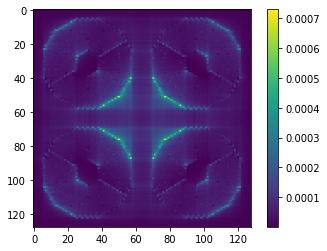

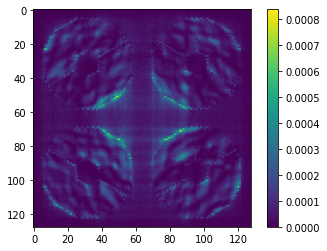

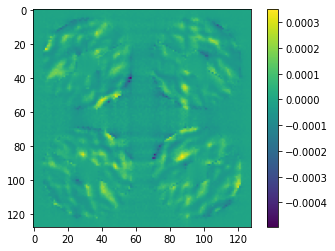

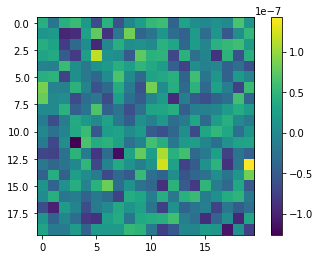

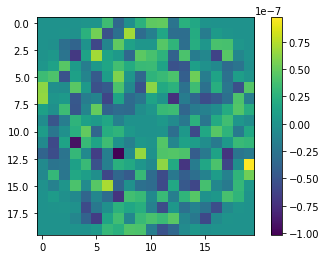

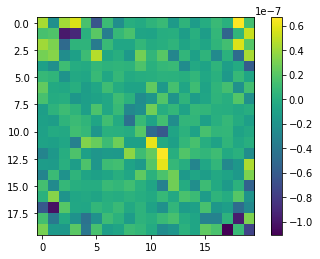

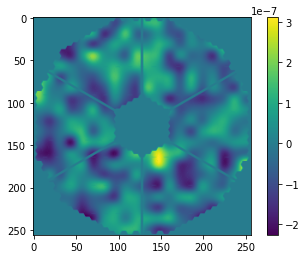

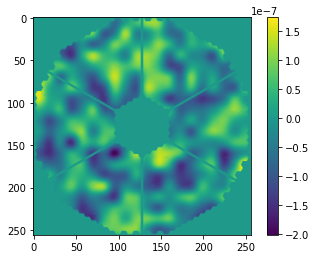

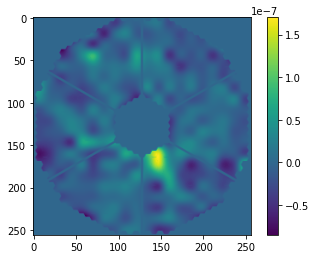

0
1
2
3
4
5
6
7
8
9


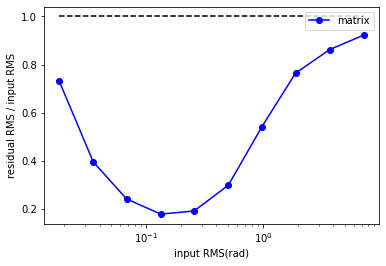

In [7]:
#make RMS plot
%matplotlib inline
#for testing and plotting
def test_per_image():
    for i in range(len(rmslist)):
        dm_state = testy[i*100]
        print(testx[i].reshape(1, 64, 64, 4).shape)
        cnn_pred = model.predict((testx[i*100] / np.sqrt(np.var(testx[i*100]))).reshape(1, 64, 64, 4)) * np.sqrt(np.var(testy[i*100]))
        plt.imshow((dm_state - cnn_pred).reshape(20, 20))
        plt.colorbar()
        plt.title("difference")
        plt.show()
        # print(dm_state)
        plt.imshow(dm_state.reshape(20, 20))
        plt.colorbar()
        plt.title("label")
        plt.show()
        # print(cnn_pred)
        plt.imshow(cnn_pred.reshape(20, 20))
        plt.colorbar()
        plt.title("prediction")
        plt.show()
    asdadsads


transf_matrix = influence_functions.transformation_matrix.toarray().transpose()*2
opd_dm_states = np.matmul(testy, transf_matrix)

#IMPORT MODEL
# model = keras.models.load_model("./models/testmodel")
# model.summary()

# test_per_image()


#normalize data and predict actuator states
data_variances = np.sqrt(np.var(testx, axis=1))
label_variances = np.sqrt(np.var(testy, axis=1))
# cnnpredictions = model.predict((testx / data_variances[:,None]).reshape(len(testx), int(num_pwfs_pixels/2), int(num_pwfs_pixels/2), 4)) * label_variances[:,None]
# opd_cnnpredictions = np.matmul(cnnpredictions, transf_matrix)

#reshape 4 seperate images from pyramid into 1 image
measurements = np.zeros((len(testx), num_pwfs_pixels, num_pwfs_pixels))
h = int(num_pwfs_pixels/2)
measurements[:, :h, :h] = testx[:, :, 0].reshape(len(testx), h, h)
measurements[:, h:, :h] = testx[:, :, 1].reshape(len(testx), h, h)
measurements[:, :h, h:] = testx[:, :, 2].reshape(len(testx), h, h)
measurements[:, h:, h:] = testx[:, :, 3].reshape(len(testx), h, h)
measurements = measurements.reshape(len(testx), num_pwfs_pixels**2)

#predict actuator states linearly
matrixpredictions = np.matmul(measurements - image_ref[None,:], matrix.transpose())
opd_matrixpredictions = np.matmul(matrixpredictions, transf_matrix)

opd_dm_states *= aperture
# opd_cnnpredictions *= aperture
opd_matrixpredictions *= aperture

viewindex = 500
plt.imshow(image_ref.reshape(128, 128))
plt.colorbar()
plt.show()
plt.imshow(measurements[viewindex].reshape(128, 128))
plt.colorbar()
plt.show()
plt.imshow((measurements[viewindex] - image_ref).reshape(128, 128))
plt.colorbar()
plt.show()
plt.imshow(testy[viewindex].reshape(20, 20))
plt.colorbar()
plt.show()
plt.imshow(matrixpredictions[viewindex].reshape(20, 20))
plt.colorbar()
plt.show()
plt.imshow(testy[viewindex].reshape(20, 20) - matrixpredictions[viewindex].reshape(20, 20))
plt.colorbar()
plt.show()
plt.imshow(opd_dm_states[viewindex].reshape(256, 256))
plt.colorbar()
plt.show()
plt.imshow(opd_matrixpredictions[viewindex].reshape(256, 256))
plt.colorbar()
plt.show()
plt.imshow(opd_dm_states[viewindex].reshape(256, 256) - opd_matrixpredictions[viewindex].reshape(256, 256))
plt.colorbar()
plt.show()



#calculate RMS, note that I devide by sum of aperture instead of length of aperture since the edges are often a float between 1 and 0 instead of an int
inputs = []
matrix_outputs = []
cnn_outputs = []
for i in range(len(rmslist)):
    print(i)
    input_rms = np.sqrt(np.sum(opd_dm_states[i*nr_runs:(i+1)*nr_runs]**2, axis=1) / np.sum(aperture)) / wavelength_wfs * 2*np.pi
    matrix_rms = np.sqrt(np.sum((opd_matrixpredictions[i*nr_runs:(i+1)*nr_runs] - opd_dm_states[i*nr_runs:(i+1)*nr_runs])**2, axis=1) / np.sum(aperture)) / wavelength_wfs * 2*np.pi
    # cnn_rms = np.sqrt(np.sum((opd_cnnpredictions[i*nr_runs:(i+1)*nr_runs] - opd_dm_states[i*nr_runs:(i+1)*nr_runs])**2, axis=1) / np.sum(aperture)) / wavelength_wfs * 2*np.pi
    
    inputs.append(np.mean(input_rms))
    matrix_outputs.append(np.mean(matrix_rms/input_rms))
    # cnn_outputs.append(np.mean(cnn_rms/input_rms))
  
plt.hlines(1, np.min(inputs), np.max(inputs), linestyles="dashed")
plt.semilogx(inputs, matrix_outputs, marker="o", color="blue", label="matrix")
# plt.semilogx(inputs, cnn_outputs, marker="o", color="green", label="cnn")
plt.xlabel("input RMS(rad)")
plt.ylabel("residual RMS / input RMS")
plt.legend()
plt.show()

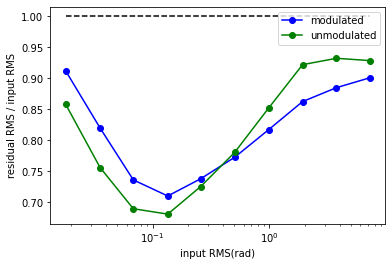

In [ ]:
# modulatedMatrixY = matrix_outputs
# modulatedMatrixX = inputs
# matrixY = matrix_outputs

# modulatedCnnY = cnn_outputs
# CnnY = cnn_outputs

plt.hlines(1, np.min(inputs), np.max(inputs), linestyles="dashed")
plt.semilogx(inputs, modulatedCnnY, marker="o", color="blue", label="modulated")
plt.xlabel("input RMS(rad)")
plt.ylabel("residual RMS / input RMS")
plt.semilogx(inputs, CnnY, marker="o", color="green", label="unmodulated")
plt.xlabel("input RMS(rad)")
plt.ylabel("residual RMS / input RMS")
plt.legend()
plt.show()